![logo](https://climate.copernicus.eu/sites/default/files/custom-uploads/branding/LogoLine_horizon_C3S.png)

<br>

# Calculation of global distribution and timeseries of Outgoing Longwave Radiation (OLR) using NOAA/NCEI HIRS data

**This notebook can be run on free online platforms, such as Binder, Kaggle and Colab, or they can be accessed from GitHub. The links to run this notebook in these environments are provided here, but please note they are not supported by ECMWF.**

[![binder](https://mybinder.org/badge.svg)](https://mybinder.org/v2/gh/ecmwf-training/c3s-training-submodule-sat-obs-atmos-physics/main?labpath=erb-outgoing-longwave-radiation.ipynb)
[![kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/ecmwf-training/c3s-training-submodule-sat-obs-atmos-physics/blob/main/erb-outgoing-longwave-radiation.ipynb)
[![colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ecmwf-training/c3s-training-submodule-sat-obs-atmos-physics/blob/main/erb-outgoing-longwave-radiation.ipynb)
[![github](https://img.shields.io/badge/Open%20in-GitHub-black?logo=github)](https://github.com/ecmwf-training/c3s-training-submodule-sat-obs-atmos-physics/blob/main/erb-outgoing-longwave-radiation.ipynb)

## Learning objectives 🎯

This notebook-tutorial provides a practical introduction to the HIRS dataset available on 
[C3S Earth's radiation budget from 1979 to present derived from satellite observations](https://cds-beta.climate.copernicus.eu/datasets/satellite-earth-radiation-budget?tab=overview).  

The Top-of-atmosphere (TOA) Outgoing Longwave Radiation (OLR) is one of the Global Climate Observing System (GCOS) Essential Climate Variables (ECV), and it is a key component of the Earth’s Radiation Budget (ERB). OLR combines the thermal radiation from the atmosphere and the thermal radiation from the Earth’s surface that leaves the atmosphere through the “window” regions of the electromagnetic spectrum. OLR is the reason why the Earth is not heating up indefinitely by the Sun. OLR has a latitudinal dependence, but it is not uniform mostly because of the difference in the cloud cover. The biggest volcanic eruptions emit small particles in the stratosphere, where they stay for decades and can reduce the global OLR for years. During the last decades, the average temperatures in the Arctic region have risen significantly. The Arctic region is mostly cloudless, so the longwave emission from the Earth contributes to the TOA OLR.

We give a short introduction to the ECV Earth Radiation Budget, Outgoing Longwave Radiation (OLR) and provide three use cases of the dataset: plot the time-averaged global distribution of OLR (Use Case 1), calculate global timeseries of OLR (Use Case 2) and plot the Arctic weighted mean timeseries between 1979 and 2019 (Use Case 3).
We provide step-by-step instructions on data preparation. Use cases come with extensive documentation and each line of code is explained.  
Two figures below are results of Use Case 1 and 2, and the result of a successful run of the code.

![](./img/hirs_olr_banner.png)

## Prepare your environment

### Set up CDSAPI and your credentials

The code below will ensure that the `cdsapi` package is installed. If you have not setup your `~/.cdsapirc` file with your credenials, you can replace `None` with your credentials that can be found on the [how to api](https://cds.climate.copernicus.eu/how-to-api) page (you will need to log in to see your credentials).

In [1]:
!pip install -q cdsapi
# If you have already setup your .cdsapirc file you can leave this as None
cdsapi_key = None
cdsapi_url = None

### (Install and) Import libraries


In [2]:
# CDS API library
import cdsapi

# Libraries for working with multidimensional arrays
import xarray as xr
import numpy as np
import pandas as pd

# Library to work with zip-archives, OS-functions and pattern expansion
import zipfile
import os

# Libraries for plotting and visualising data
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Disable warnings for data download via API
import urllib3
urllib3.disable_warnings()


### Specify data directory

In [3]:
# Directory to store data
# Please ensure that datadir is a location where you have write permissions
DATADIR = './data_dir/'
# Create this directory if it doesn't exist
os.makedirs(DATADIR, exist_ok=True)

# Filename for the zip file downloaded from the CDS
download_zip_file = os.path.join(DATADIR, 'olr-monthly_v02r07.zip')
# Filename for the netCDF file which contain the merged contents of the monthly files.
merged_netcdf_file = os.path.join(DATADIR, 'olr-monthly_v02r07_197901_202207.nc')

## Explore data

In the Copernicus Climate Data Store (CDS), a dataset of OLR has been brokered from the High Resolution Infrared Radiation Sounder (HIRS) Outgoing Longwave Radiation (OLR) Climate Data Record (CDR) version v02r07. The Copernicus Climate Change Service (C3S) CDS provides both data produced specifically for C3S and so-called brokered products. The later are existing products produced under an independent programme or project which are made available through the CDS. This widely used CDR has been produced by the NOAA/NCEI from the HIRS instruments on board the US NOAA and European MetOp satellites. It provides monthly means of the Thermal (Longwave) Radiation Fluxes at the Top of the Atmosphere (TOA) from January 1979 to present, with global coverage and at a 2.5° x 2.5° spatial resolution.

Please find further information about the dataset as well as the data in the Climate Data Store catalogue entry Earth's Radiation Budget, sections "Overview", "Download data" and "Documentation": 
- [Earth's Radiation Budget from 1979 to present derived from satellite observations](https://cds-beta.climate.copernicus.eu/datasets/satellite-earth-radiation-budget?tab=overview)

The tutorial video describes the "Earth Radiation Budget" Essential Climate Variable and the methods and satellite instruments used to produce the data provided in the CDS catalogue entry:  
- [Tutorial video on the Earth Radiation Budget Essential Climate Variable](https://datastore.copernicus-climate.eu/documents/satellite-earth-radiation-budget/C3S_D312b_Lot1.4.2.5_201902_Tutorial_ECVEarthRadiationBudget_v1.4.mp4)

#### Search for data

To search for data, visit the CDS website: https://cds-beta.climate.copernicus.eu/.
Here you can search for HIRS OLR data using the search bar. The data we need for this use case is the [Earth's Radiation Budget from 1979 to present derived from satellite observations](https://cds-beta.climate.copernicus.eu/datasets/satellite-earth-radiation-budget?tab=overview).
The Earth Radiation Budget (ERB) comprises the quantification of the incoming radiation from the Sun and the outgoing reflected shortwave and emitted longwave radiation. This catalogue entry comprises data from a number of sources.

Having selected the correct catalogue entry, we now need to specify what origin, variables, temporal and geographic coverage we are interested in. 
These can all be selected in the **"Download data"** tab. In this tab a form appears in which we will select the following parameters to download:

::: {dropdown} Parameters of data to download

- Origin: `NOAA/NCEI HIRS`
- Variable: `Outgoing longwave radiation`
- Year: `1979 to present` (use "Select all" button)
- Month: `all`
- Geographical area: `Whole available region` 
- Format: `Compressed zip file (.zip)`

:::

At the end of the download form, select "Show API request". This will reveal a block of code, which you can simply copy and paste into a cell of your Jupyter Notebook (see cell below). Having copied the API request into the cell below, running this will retrieve and download the data you requested into your local directory.

::: {warning}

Please remember to accept the terms and conditions of the dataset, at the bottom of the CDS download form!

:::

### Download the data

With the API request copied into the cells below, running these cells will retrieve and download the data you requested into your local directory.

In [4]:
c = cdsapi.Client()
c.retrieve(
    'satellite-earth-radiation-budget',
    {
        'download_format': 'zip',
        'product_family':'hirs',
        'origin': 'noaa_ncei',
        'variable': ['outgoing_longwave_radiation'],
        'climate_data_record_type':'thematic_climate_data_record',
        'time_aggregation':'monthly_mean',
        'year': ['%04d' % (year) for year in range(1979, 2023)],
        'month': ['%02d' % (mnth) for mnth in range(1, 13)],
        'version': ['2_7_reprocessed']
    },
    download_zip_file
)

2025-09-11 17:31:56,151 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-09-11 17:31:56,367 INFO [2025-04-24T00:00:00] EBAF version has been increased from Ed 4.2 to Ed 4.2.1. Please see the Known issues section under the Documentation tab for more details.
2025-09-11 17:31:56,368 INFO Request ID is dd3a46a9-cdce-472b-b5c2-68e802ac7701
2025-09-11 17:31:56,448 INFO status has been updated to accepted
2025-09-11 17:32:29,265 INFO status has been updated to successful


e28dd28cd0cf7f1776587afdb995c692.zip:   0%|          | 0.00/24.6M [00:00<?, ?B/s]

'./data_dir/olr-monthly_v02r07.zip'

### Unpack and merge data

The zip files are now requested and downloaded to the data directory that we specified earlier.
For the purposes of this tutorial, we will unzip the archive and merge all files into one NetCDF file.
After that, we delete all individual files.
    

In [5]:
# Unzip the data. The dataset is split in monthly files.
# Full HIRS dataset consists of more than 500 files.
with zipfile.ZipFile(download_zip_file, 'r') as zip_ref:
    filelist = [os.path.join(DATADIR, f) for f in zip_ref.namelist()]
    zip_ref.extractall(DATADIR)
# Ensure the filelist is in the correct order:
filelist = sorted(filelist)

# Merge all unpacked files into one.
ds = xr.open_mfdataset(filelist, concat_dim='time', combine='nested')
ds.to_netcdf(merged_netcdf_file)

# Recursively delete unpacked data, using library glob,
# that enables Unix style pathname pattern expansion
for f in filelist:
    os.remove(f)

## **Use case 1**: climatology of the Outgoing Longwave Radiation (OLR)

Firstly, we should get an overview of the parameter by plotting the time-averaged global distribution. 
The data are stored in NetCDF format, and we will use Xarray library to work with the data. 
We will then use Matplotlib and Catropy to visualise the data.

### Load dataset, subselect and calculate temporal mean

We load the NetCDF file with the library [xarray](https://docs.xarray.dev/en/stable/index.html) and the function `open_dataset()`. We receive the `xarray.Dataset` that has one data variable (OLR) and three dimensions: time: 480 steps, latitude: 72, and longitude: 144. This data type has also a number of attributes with auxiliary information about the data. <br>
Next, we want to select the specific time range for the plotting from January 1979 to December 2018. Xarray has a method `sel` that indexes the data and dimensions by the appropriate indexers.
We use the method `mean` to applying mean along the time dimension. 

In [6]:
# Read data and calculate the global mean.
xdf = xr.open_dataset(merged_netcdf_file, decode_times=True, mask_and_scale=True)
xdf = xdf.sel(time=slice('1979-01-01', '2019-01-01'))

# calculate the mean along the time dimension
xdf_m = xdf.olr.mean(dim=['time'])

### Calculate temporal mean and convert longitude to [-180, 180] grid

The code below shifts the longitude dimension from [1.25 to 358.75] to [-178.75, 178.75]. We also sort the longitude values in ascending order.

In [7]:
xdf_m.coords['lon'] = ((xdf_m['lon'] + 180) % 360) - 180
xdf_m = xdf_m.loc[{'lon': sorted(xdf_m.coords['lon'].values)}]

### Plot data

First, we want to save objects `figure` and `axes` to use later. [Cartopy](https://scitools.org.uk/cartopy/docs/latest/) can transform data arrays on different geographic projections. We use Cartopy in combination with [Matplotlib](https://matplotlib.org/stable/index.html) to create a high-quality plot. `Pcolormesh` doesn't work with data arrays with NaNs. Before plotting we convert DataArray to the numpy MaskedArray.

<>:36: SyntaxWarning: invalid escape sequence '\ '
<>:36: SyntaxWarning: invalid escape sequence '\ '
/var/folders/l2/529q7bzs665bnrn7_wjx1nsr0000gn/T/ipykernel_62573/1853587143.py:36: SyntaxWarning: invalid escape sequence '\ '
  '$\\bf{Mean\ OLR\ from\ HIRS\ Ed:2.7\ (January\ 1979-December\ 2018)}$',
/var/folders/l2/529q7bzs665bnrn7_wjx1nsr0000gn/T/ipykernel_62573/1853587143.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap=plt.cm.get_cmap('YlOrRd'),


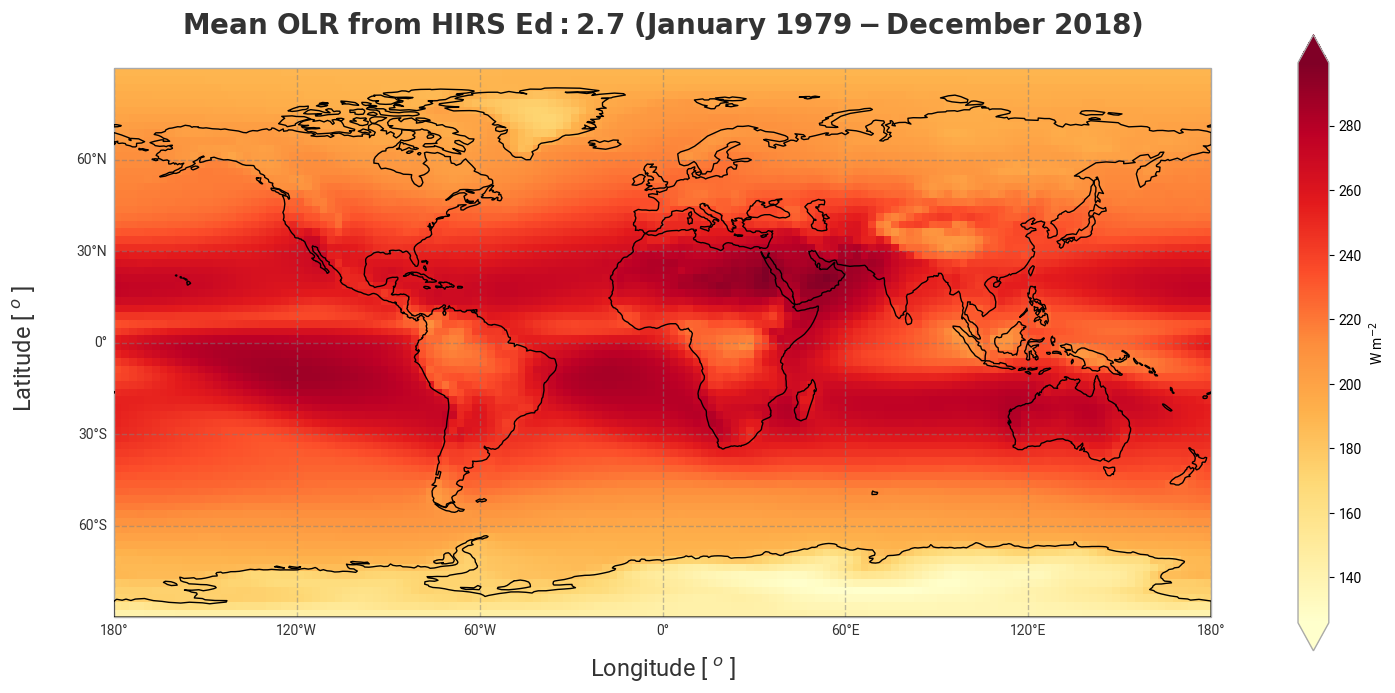

In [8]:
fig1 = plt.figure(figsize=(16, 8))
ax1 = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())

masked_average = xdf_m.to_masked_array()  # mask the data because pcolormesh cannot plot nan-values
im = plt.pcolormesh(
    xdf_m['lon'][:],
    xdf_m['lat'][:],
    masked_average,
    cmap=plt.cm.get_cmap('YlOrRd'),
    transform=ccrs.PlateCarree()
)

# Modify figure style; add lat/lon grid and labels
# NOTE: There is a known issue with the coastlines for the pip installation of cartopy,
#   The following is a work-around, and not required if using cartopy
# ax1.coastlines(color='black')
ax1.add_feature(cfeature.LAND, edgecolor='black', facecolor="none", linewidth=1, zorder=3)

gl = ax1.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False  # hide top and right labels
gl.right_labels = False
'''
Cartopy's matplotlib gridliner takes over the xlabel and ylabel and uses it to manage
grid lines and labels.
To add labels we need to add text to the Axes, such as:'''
ax1.text(
    -0.07, 0.49, 'Latitude [ $^o$ ]', fontsize=17, va='bottom', ha='center',
    rotation='vertical', rotation_mode='anchor', transform=ax1.transAxes)
ax1.text(
    0.5, -0.12, 'Longitude [ $^o$ ]', fontsize=17, va='bottom', ha='center',
    rotation='horizontal', rotation_mode='anchor', transform=ax1.transAxes)
# Add colorbar
cb = fig1.colorbar(im, ax=ax1, label='W m$^{-2}$', fraction=0.045, pad=0.07, extend='both')
# Add title text
ax1.set_title(
    '$\\bf{Mean\ OLR\ from\ HIRS\ Ed:2.7\ (January\ 1979-December\ 2018)}$',
    fontsize=20, pad=25)

# and save the figure
fig1.savefig('./Example_1_HIRS_olr_mean.png', dpi=500, bbox_inches='tight')

**Figure 1** shows the time-averaged Outgoing Longwave Radiation over the period January 1979 -
December 2018. The maximum values of the OLR are found in the tropics and it decreases toward the
poles. The relative minimum near the equator, in yellow colour, corresponds to the ITCZ and the
convection areas, where persistent and relatively high cloud cover reduces the LW radiation at the
TOA. Antarctica is cooler than the corresponding northern latitudes (Harrison et al.).

## **Use case 2**: global time series of the OLR

After looking at the time-averaged global distribution, in the next step, we further investigate the dataset. The OLR dataset is more than 40 years long, and another useful way of visualizing is the time series. We will calculate the global time series, plot it, and discuss the most important features.

We start by opening the combined data with Xarray `open_dataset` function 
and subselect a time range from January 1979 to December 2018.

In [9]:
xdf = xr.open_dataset(merged_netcdf_file, decode_times=True, mask_and_scale=True)
xdf = xdf.sel(time=slice('1979-01-01', '2019-01-01'))

### Apply weights and calculate the rolling mean

Next, we need to to account for differences in area of grid cells for polar and equatorial regions. We give different weights for polar and equatorial regions, and the way to do this is to use the cosine of the latitude. We then calculate the global values by using `sum` method. And we calculate the 12-month rolling mean by using the `rolling` method.



In [10]:
# calculate normalized weights
_, lat_field = np.meshgrid(xdf.lon.values, xdf.lat.values)
weight = np.cos(np.pi * lat_field / 180)
data = np.ma.masked_invalid(xdf.olr)
weight[data.mask[0, :, :]] = np.nan
weight_normalized = weight / np.nansum(weight)

# Add weights as second Xarray Data variable and apply weights to the OLR
xdf['weight_normalized'] = xr.DataArray(
    weight_normalized, coords=[xdf.lat.values, xdf.lon.values], dims=['lat', 'lon'])
xdf['olr_norma'] = xdf.olr * xdf.weight_normalized

# calculate the global values
xdf_m = xdf.olr_norma.sum(dim=['lat', 'lon'])
# calculate the 12-month rolling mean
xdf_mean_rolling = xdf_m.rolling(time=12, center=True).mean().dropna('time')

### Plot data

Now, let's visualize the time series. Xarray offers built-in matplotlib methods to plot Data Arrays. We use the method `plot` to get the plot.<br>
We also want to add custom xticks. Our x-axis is the time, and one of the ways to work with the time variable is to use library Pandas. This library can work with both date and time. We use method `date_range` to generate the ticks with frequency of two years.

<>:5: SyntaxWarning: invalid escape sequence '\ '
<>:5: SyntaxWarning: invalid escape sequence '\ '
/var/folders/l2/529q7bzs665bnrn7_wjx1nsr0000gn/T/ipykernel_62573/87006804.py:5: SyntaxWarning: invalid escape sequence '\ '
  plt.title('$\\bf{HIRS\ OLR-Globe }$\nYearly rolling mean')


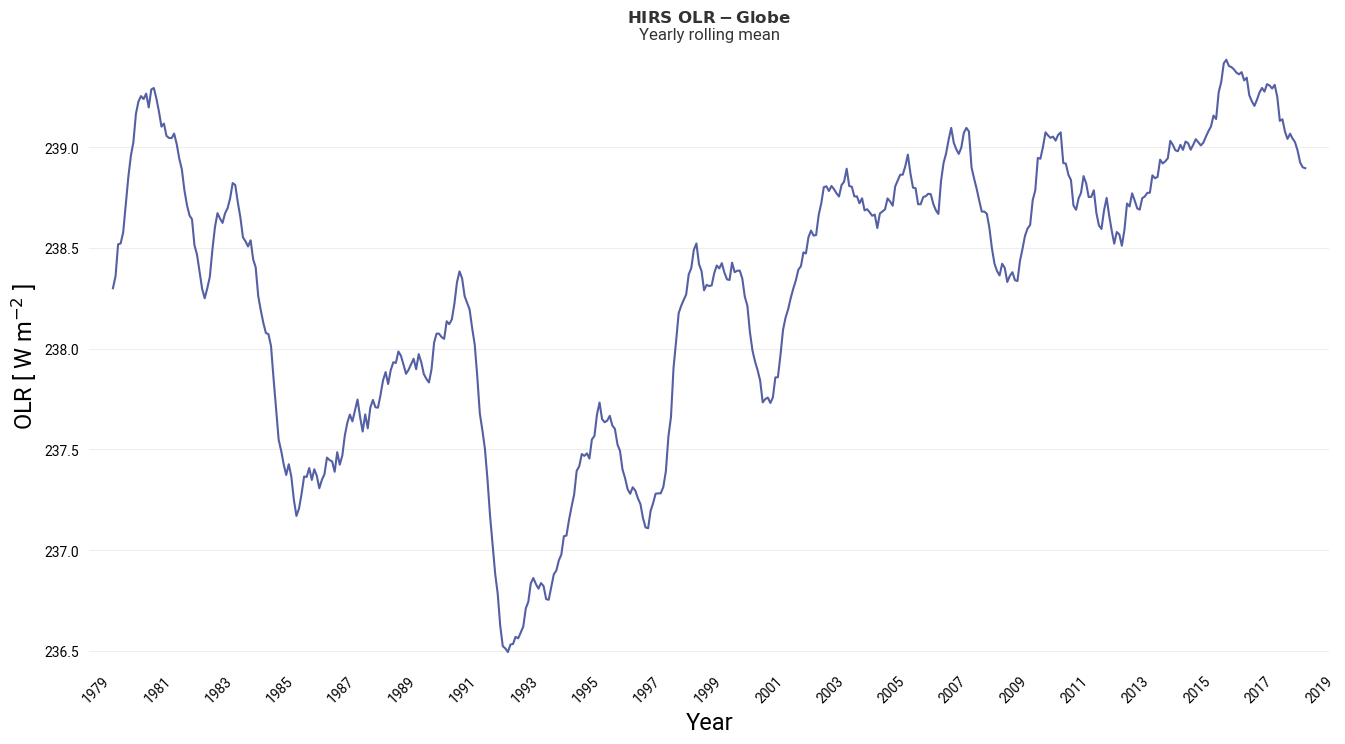

In [11]:
# Plotting.
xdf_mean_rolling.plot(figsize=[16, 8])

# Add title, x- and y-labels
plt.title('$\\bf{HIRS\ OLR-Globe }$\nYearly rolling mean')
plt.ylabel("OLR [ W m$^{-2}$ ]", fontsize=17)
plt.xlabel("Year", fontsize=17)

# Custom x-ticks
dateStart = pd.to_datetime('1979-01-01', format='%Y-%m-%d')
date_End = pd.to_datetime('2019-01-01', format='%Y-%m-%d')
dates_rng = pd.date_range(dateStart, date_End, freq='2YS')
plt.xticks(dates_rng, [dtz.strftime('%Y') for dtz in dates_rng], rotation=45)

plt.savefig('./Example_2_olr_timeserie_Globe.png', dpi=500, bbox_inches='tight')

**Figure 2**, shows the evolution of the global mean of the OLR using a 12-month rolling mean. This long
CDR shows some interesting features such as the drop of OLR due to a global radiative perturbation
in response to volcanic eruptions, for instance, El Chichon in 1982 and Pinatubo in 1991. The main
atmospheric thermal effects of these two eruptions persist for about two years after the eruption.
The figure also shows some inter-annual variations that are suggested to be related to “El Niño” or
“La Niña” Southern Oscillation.

## **Use case 3**: OLR evolution in the Arctic

In the final use case, we will calculate, plot and discuss the OLR time series in the Arctic region. We can re-use code from the previous use case, but we need to add one additional step: select the Arctic region from the original global dataset. <br>

We start by reading the dataset with xarray `open_dataset` method. We have used `sel` method before to select the data based on time coordinate. This time, we will select the latitude coordinate label.

<>:30: SyntaxWarning: invalid escape sequence '\ '
<>:30: SyntaxWarning: invalid escape sequence '\ '
/var/folders/l2/529q7bzs665bnrn7_wjx1nsr0000gn/T/ipykernel_62573/880090580.py:30: SyntaxWarning: invalid escape sequence '\ '
  plt.title('$\\bf{HIRS\ OLR-Arctic\ [70°N, 90°N] }$\nYearly rolling mean')


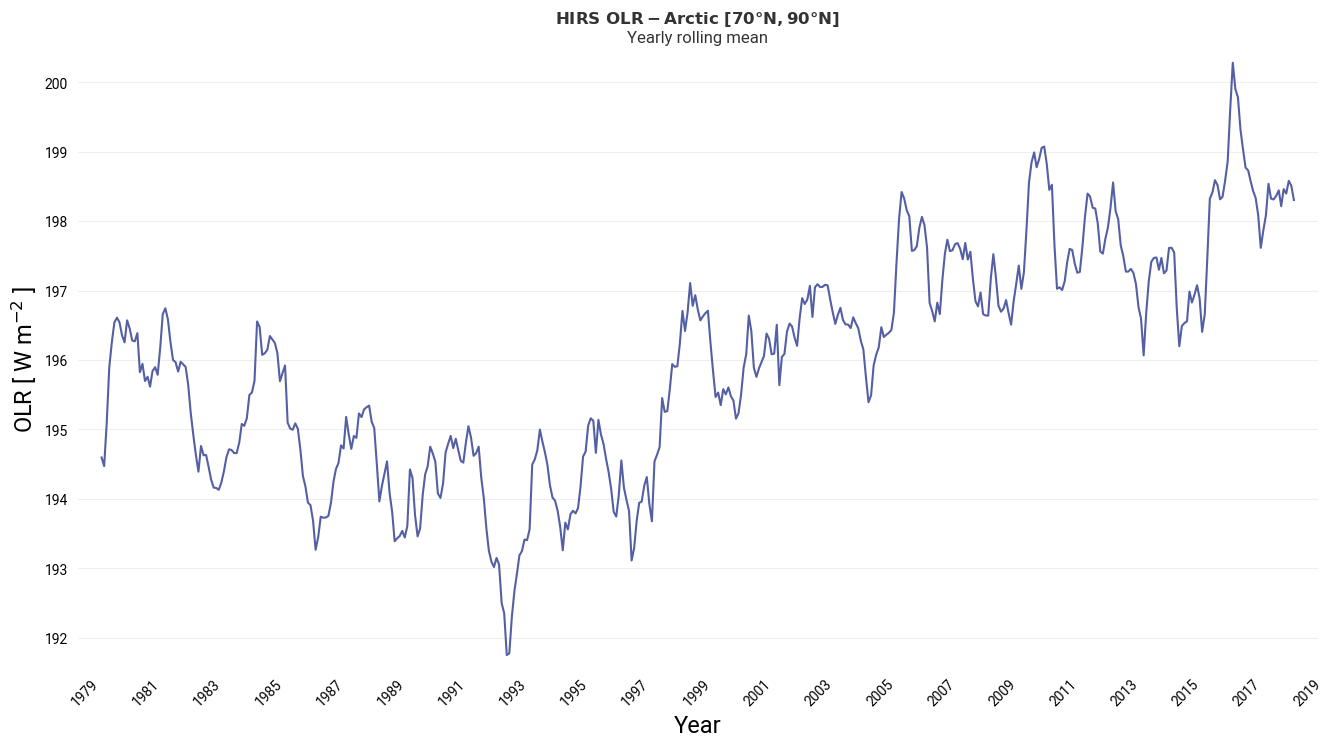

In [12]:
# Read the dataset
xdf = xr.open_dataset(merged_netcdf_file, decode_times=True, mask_and_scale=True)

# Select time and latitude range
xdf = xdf.sel(time=slice('1979-01-01', '2019-01-01'))
lat_slice = slice(70, 90)
xdf = xdf.sel(lat=lat_slice)

# Calculate normalized weights
_, lat_field = np.meshgrid(xdf.lon.values, xdf.lat.values)
weight = np.cos(np.pi*lat_field/180)
data = np.ma.masked_invalid(xdf.olr)
weight[data.mask[0, :, :]] = np.nan
weight_normalized = weight / np.nansum(weight)

# Add weights as second Xarray Data variable and apply weights to the OLR
xdf['weight_normalized'] = xr.DataArray(
    weight_normalized, coords=[xdf.lat.values, xdf.lon.values], dims=['lat', 'lon'])
xdf['olr_norma'] = xdf.olr * xdf.weight_normalized

# calculate the global values
xdf_m = xdf.olr_norma.sum(dim=['lat', 'lon'])
# calculate the 12-month rolling mean
xdf_Arctic_mean_rolling = xdf_m.rolling(time=12, center=True).mean().dropna('time')

# Plotting.
xdf_Arctic_mean_rolling.plot(figsize=[16, 8])

# Add title, x- and y-labels
plt.title('$\\bf{HIRS\ OLR-Arctic\ [70°N, 90°N] }$\nYearly rolling mean')
plt.ylabel("OLR [ W m$^{-2}$ ]", fontsize=17)
plt.xlabel("Year", fontsize=17)

# Custom x ticks
dateStart = pd.to_datetime('1979-01-01', format='%Y-%m-%d')
date_End = pd.to_datetime('2019-01-01', format='%Y-%m-%d')
dates_rng = pd.date_range(dateStart, date_End, freq='2YS')
plt.xticks(dates_rng, [dtz.strftime('%Y') for dtz in dates_rng], rotation=45)

# Save figure to the disk 
plt.savefig('./Example_3_olr_timeserie_Arctic.png', dpi=500, bbox_inches='tight')

**Figure 3**, shows the evolution of the OLR in the Arctic region [70°N-90°N] for the period 1979-2019
also using a yearly rolling mean. From the image, we can infer an increase in the OLR in the Arctic
region with time. This increase is strongly marked as from 1998 and in line with the increase of
temperature in the Arctic (Hansen et al, 2010), while the relative stability of the first part of the time
series is more difficult to interpret due to the major volcanic eruptions in this period.

## Get more information about Earth radiation budget:

- [Earth's radiation budget from 1979 to present derived from satellite observations](https://cds-beta.climate.copernicus.eu/datasets/satellite-earth-radiation-budget?tab=overview)
- [Climate Data Store](https://cds-beta.climate.copernicus.eu/)



## References

Hansen, J., Ruedy, R., Sato, M., & Lo, K., (2010). _Global surface temperature change_. Reviews of Geophysics, 48(4).

Harrison, E.F., Gurney, R. J., Foster, J. L., Gurney, R. J., & Parkinson, C. L. (1993). _Atlas of satellite observations related to global change_. Chapter: Radiation Budget at the top of the atmosphere. Cambridge University Press.